*   Autorius: Paulina Ivanauskaitė
*   LSP: 2213728
*   Variantas: Naudotos paukščio, katės ir šuns klasės

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install fiftyone

import os
import math
import random
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.openimages as fouo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.7 MB/s eta 0:

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, target_size=(256, 256)):
        self.root_dir = root_dir
        self.is_train = is_train
        self.custom_transform = transform
        self.target_size = target_size

        self.class_to_idx = {'Background': 0}
        mapping_file = os.path.join(os.path.dirname(root_dir), "class_mapping.txt")
        if os.path.exists(mapping_file):
            with open(mapping_file, 'r') as f:
                for line in f.readlines():
                    if ':' in line and not line.startswith("Class"):
                        idx, name = line.strip().split(': ')
                        self.class_to_idx[name] = int(idx)

        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')

        os.makedirs(self.img_dir, exist_ok=True)
        os.makedirs(self.mask_dir, exist_ok=True)

        self.samples = []
        if os.path.exists(self.img_dir) and os.path.exists(self.mask_dir):
            for img_file in os.listdir(self.img_dir):
                if img_file.endswith('.jpg') or img_file.endswith('.png'):
                    mask_file = os.path.splitext(img_file)[0] + "_mask.png"
                    if os.path.exists(os.path.join(self.mask_dir, mask_file)):
                        self.samples.append((img_file, mask_file))

        print(f"Found {len(self.samples)} images with masks")

    def __len__(self):
        return len(self.samples)

    def transform(self, img, mask):
        img = transforms.functional.resize(img, self.target_size, interpolation=transforms.InterpolationMode.BILINEAR)
        mask = transforms.functional.resize(mask, self.target_size, interpolation=transforms.InterpolationMode.NEAREST)

        if self.is_train:
            if random.random() > 0.5:
                img = transforms.functional.hflip(img)
                mask = transforms.functional.hflip(mask)

            if random.random() > 0.5:
                angle = random.choice([-10, -5, 5, 10])
                img = transforms.functional.rotate(img, angle)
                mask = transforms.functional.rotate(mask, angle, fill=0)

        img = transforms.functional.to_tensor(img)
        img = transforms.functional.normalize(img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

    def __getitem__(self, idx):
        img_file, mask_file = self.samples[idx]

        try:
            img_path = os.path.join(self.img_dir, img_file)
            mask_path = os.path.join(self.mask_dir, mask_file)

            img = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')

            if self.custom_transform:
                return self.custom_transform(img, mask)
            else:
                return self.transform(img, mask)
        except Exception as e:
            print(f"Error loading {img_file} or {mask_file}: {e}")
            return torch.zeros((3, *self.target_size)), torch.zeros(self.target_size, dtype=torch.long)

In [12]:
def download_openimages_segmentation(drive_path, selected_classes,
                                    samples=1000, split_ratio=0.8):
    base_dir = Path(drive_path)
    base_dir.mkdir(exist_ok=True)

    data_dir = base_dir / "openimages_segmentation"
    train_dir = data_dir / "train"
    test_dir = data_dir / "test"

    for directory in [data_dir, train_dir, test_dir]:
        for subdir in ["images", "masks"]:
            (directory / subdir).mkdir(parents=True, exist_ok=True)

    if len(list((train_dir / "images").glob("*.jpg"))) > 0:
        print(f"Dataset already exists at {data_dir}. Skipping download.")
    else:

        print(f"Downloading OpenImages dataset with classes: {selected_classes}")
        dataset = foz.load_zoo_dataset(
            "open-images-v6",
            split="validation",
            label_types=["segmentations"],
            classes=selected_classes,
            max_samples=samples,
            dataset_name="openimages_segmentation_temp"
        )

        class_counts = {cls: 0 for cls in selected_classes}

        for sample_idx, sample in enumerate(tqdm(dataset, desc="Processing samples")):
            if hasattr(sample, 'ground_truth') and sample.ground_truth:
                if len(sample.ground_truth.detections) > 0:
                    img_path = sample.filepath

                    if not os.path.exists(img_path):
                        print(f"Image not found: {img_path}")
                        continue

                    try:
                        img = cv2.imread(img_path)
                        if img is None:
                            print(f"Failed to read image: {img_path}")
                            continue

                        height, width = img.shape[:2]

                        mask = np.zeros((height, width), dtype=np.uint8)

                        classes_in_image = set()

                        for detection in sample.ground_truth.detections:
                            class_name = detection.label

                            if class_name in selected_classes:
                                classes_in_image.add(class_name)

                                if hasattr(detection, 'mask') and detection.mask is not None:
                                    detection_mask = detection.mask
                                    if detection_mask.shape[:2] != (height, width):
                                        mask_height, mask_width = detection_mask.shape[:2]

                                        new_mask = np.zeros((height, width), dtype=bool)

                                        scale_x = width / mask_width
                                        scale_y = height / mask_height

                                        if hasattr(detection, 'bounding_box'):
                                            x, y, w, h = detection.bounding_box
                                            x1 = int(x * width)
                                            y1 = int(y * height)
                                            x2 = int((x + w) * width)
                                            y2 = int((y + h) * height)

                                            mask_resized = cv2.resize(
                                                detection_mask.astype(np.uint8),
                                                (x2 - x1, y2 - y1),
                                                interpolation=cv2.INTER_NEAREST
                                            ).astype(bool)

                                            new_mask[y1:y2, x1:x2] = mask_resized
                                        else:
                                            scale = min(scale_x, scale_y)
                                            new_width = int(mask_width * scale)
                                            new_height = int(mask_height * scale)

                                            mask_resized = cv2.resize(
                                                detection_mask.astype(np.uint8),
                                                (new_width, new_height),
                                                interpolation=cv2.INTER_NEAREST
                                            ).astype(bool)

                                            x_offset = (width - new_width) // 2
                                            y_offset = (height - new_height) // 2

                                            new_mask[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = mask_resized

                                        detection_mask = new_mask

                                    class_idx = selected_classes.index(class_name) + 1
                                    mask_overlay = detection_mask.astype(np.uint8) * class_idx

                                    mask = np.where(mask_overlay > 0, mask_overlay, mask)

                        if classes_in_image:
                            is_train = random.random() < split_ratio
                            dest_dir = train_dir if is_train else test_dir

                            img_id = os.path.basename(img_path).split('.')[0]
                            classes_str = "_".join(sorted(classes_in_image))
                            filename = f"{img_id}_{classes_str}.jpg"

                            dest_img_path = dest_dir / "images" / filename
                            cv2.imwrite(str(dest_img_path), img)

                            mask_filename = f"{img_id}_{classes_str}_mask.png"
                            mask_path = dest_dir / "masks" / mask_filename
                            cv2.imwrite(str(mask_path), mask)

                            for cls in classes_in_image:
                                class_counts[cls] += 1

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
                        continue

        dataset.delete()

        print("Samples per class:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")

    with open(data_dir / "class_mapping.txt", "w") as f:
        f.write("Class Index to Name Mapping:\n")
        f.write("0: Background\n")
        for i, class_name in enumerate(selected_classes):
            f.write(f"{i+1}: {class_name}\n")

    train_dataset = SegmentationDataset(str(train_dir), is_train=True)
    test_dataset = SegmentationDataset(str(test_dir), is_train=False)

    print(f"Dataset created with {len(train_dataset)} training samples and {len(test_dataset)} test samples")
    print(f"Dataset saved to {data_dir}")

    return train_dataset, test_dataset

In [6]:
selected_classes=['Bird', 'Cat', 'Dog']
download_openimages_segmentation("/content/drive/MyDrive/segmentation", selected_classes)

Dataset already exists at /content/drive/MyDrive/segmentation/openimages_segmentation. Skipping download.
Found 628 images with masks
Found 159 images with masks
Dataset created with 628 training samples and 159 test samples
Dataset saved to /content/drive/MyDrive/segmentation/openimages_segmentation


(<__main__.OpenImagesSegmentationDataset at 0x7df1e1849a10>,
 <__main__.OpenImagesSegmentationDataset at 0x7df1e3fd1390>)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, pool =True):
        super().__init__()

        self.encode = DoubleConv(in_channels, in_channels * 2)

    def forward(self, x):
        x = self.encode(x)
        return x

class Up(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.up = nn.Sequential(
          nn.ConvTranspose2d(out_channels * 2, out_channels, 2, 2),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
        )

        self.decode = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, y):

        x = self.up(x)
        x = torch.cat([x, y], 1)
        x = self.decode(x)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
      super(UNet, self).__init__()

      multiplier = 6

      self.pool = nn.MaxPool2d(2)

      self.encode1 = nn.Sequential(
          DoubleConv(in_channels, multiplier))
      self.encode2 = Down(multiplier)
      self.encode3 = Down(multiplier * 2)
      self.encode4 = Down(multiplier * 4)
      self.encode5 = Down(multiplier * 8)
      self.bottleneck = DoubleConv(16 * multiplier, 32 * multiplier)

      self.decode2 = Up(multiplier * 16)
      self.decode3 = Up(multiplier * 8)
      self.decode4 = Up(multiplier * 4)
      self.decode5 = Up(multiplier * 2)
      self.decode6 = Up(multiplier)

      self.extract = nn.Conv2d(multiplier, out_channels, 1)


    def forward(self, x):

        enc1 = self.encode1(x)
        x = self.pool(enc1)

        enc2 = self.encode2(x)
        x = self.pool(enc2)

        enc3 = self.encode3(x)
        x = self.pool(enc3)

        enc4 = self.encode4(x)
        x = self.pool(enc4)

        enc5 = self.encode5(x)
        x = self.pool(enc5)

        x = self.bottleneck(x)
        x = self.decode2(x, enc5)
        x = self.decode3(x, enc4)
        x = self.decode4(x, enc3)
        x = self.decode5(x, enc2)
        x = self.decode6(x, enc1)
        x = self.extract(x)

        return x

def seconds_to_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def train_epoch(optimizer, loss_func, model, loader, device):
    model.train()
    loss_acum = np.array([], dtype=np.float32)

    for data in loader:
        images = data[0].to(device)
        mask = data[1].to(device)

        pred = model(images)
        loss = loss_func(pred, mask)
        loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(loss_acum)

def calculate_metrics(y_true, y_pred, num_classes):
    y_pred = torch.argmax(y_pred, dim=1)

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    dice_scores = np.zeros(num_classes)
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)

    for c in range(num_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)

        intersection = np.logical_and(y_true_c, y_pred_c).sum()
        true_c_area = y_true_c.sum()
        pred_c_area = y_pred_c.sum()

        denominator = true_c_area + pred_c_area
        dice = 2.0 * intersection / (denominator + 1e-6) if denominator > 0 else 0
        dice_scores[c] = dice

        true_positives[c] = intersection
        false_positives[c] = pred_c_area - intersection
        false_negatives[c] = true_c_area - intersection

    micro_tp = np.sum(true_positives)
    micro_fp = np.sum(false_positives)
    micro_fn = np.sum(false_negatives)

    micro_precision = micro_tp / (micro_tp + micro_fp + 1e-6) if (micro_tp + micro_fp) > 0 else 0
    micro_recall = micro_tp / (micro_tp + micro_fn + 1e-6) if (micro_tp + micro_fn) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + 1e-6) if (micro_precision + micro_recall) > 0 else 0

    precision_per_class = true_positives / (true_positives + false_positives + 1e-6)
    recall_per_class = true_positives / (true_positives + false_negatives + 1e-6)
    f1_per_class = 2 * precision_per_class * recall_per_class / (precision_per_class + recall_per_class + 1e-6)
    macro_f1 = np.mean(f1_per_class)

    return dice_scores, micro_f1, macro_f1

In [10]:
def evaluate(model, loader, device, num_classes=4):
    model.eval()

    all_dice_scores = []
    all_micro_f1 = []
    all_macro_f1 = []

    with torch.no_grad():
        for data in loader:
            images = data[0].to(device)
            masks = data[1].to(device)

            outputs = model(images)

            dice_scores, micro_f1, macro_f1 = calculate_metrics(masks, outputs, num_classes)

            all_dice_scores.append(dice_scores)
            all_micro_f1.append(micro_f1)
            all_macro_f1.append(macro_f1)

    avg_dice_scores = np.mean(np.array(all_dice_scores), axis=0)
    avg_micro_f1 = np.mean(all_micro_f1)
    avg_macro_f1 = np.mean(all_macro_f1)

    return avg_dice_scores, avg_micro_f1, avg_macro_f1

def train_and_eval(model, loader_train, loader_valid, device, num_classes=4, epoch_count=10, lr=1e-3):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_time = datetime.now()

    train_dice_acum = []
    valid_dice_acum = []
    train_micro_f1_acum = []
    valid_micro_f1_acum = []
    train_macro_f1_acum = []
    valid_macro_f1_acum = []

    for epoch in range(epoch_count):
        loss = train_epoch(optimizer, loss_func, model, loader_train, device)

        train_dice, train_micro_f1, train_macro_f1 = evaluate(model, loader_train, device, num_classes)
        valid_dice, valid_micro_f1, valid_macro_f1 = evaluate(model, loader_valid, device, num_classes)

        train_dice_acum.append(train_dice)
        valid_dice_acum.append(valid_dice)
        train_micro_f1_acum.append(train_micro_f1)
        valid_micro_f1_acum.append(valid_micro_f1)
        train_macro_f1_acum.append(train_macro_f1)
        valid_macro_f1_acum.append(valid_macro_f1)

        current_time = datetime.now()
        elapsed = seconds_to_time((current_time - start_time).total_seconds())
        print(f'Epoch: {epoch+1}/{epoch_count}, Time: {elapsed}, Training loss: {loss:.4f}')
        print(f'  Training Dice: {np.mean(train_dice):.4f}, Micro-F1: {train_micro_f1:.4f}, Macro-F1: {train_macro_f1:.4f}')
        print(f'  Validation Dice: {np.mean(valid_dice):.4f}, Micro-F1: {valid_micro_f1:.4f}, Macro-F1: {valid_macro_f1:.4f}')

        print("  Per-class Dice scores (validation):")
        for i, dice in enumerate(valid_dice):
            class_name = "Background" if i == 0 else selected_classes[i-1]
            print(f"    {class_name}: {dice:.4f}")

    return {
        'train_dice': train_dice_acum,
        'valid_dice': valid_dice_acum,
        'train_micro_f1': train_micro_f1_acum,
        'valid_micro_f1': valid_micro_f1_acum,
        'train_macro_f1': train_macro_f1_acum,
        'valid_macro_f1': valid_macro_f1_acum
    }

def plot_metrics(metrics):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.title('Dice Score')
    plt.plot(np.mean(np.array(metrics['train_dice']), axis=1), 'b-', label='Training')
    plt.plot(np.mean(np.array(metrics['valid_dice']), axis=1), 'r-', label='Validation')
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title('Micro-F1 Score')
    plt.plot(metrics['train_micro_f1'], 'b-', label='Training')
    plt.plot(metrics['valid_micro_f1'], 'r-', label='Validation')
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title('Macro-F1 Score')
    plt.plot(metrics['train_macro_f1'], 'b-', label='Training')
    plt.plot(metrics['valid_macro_f1'], 'r-', label='Validation')
    plt.ylim(0.0, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, device, num_samples=5):
    loader = DataLoader(dataset, batch_size=1, shuffle=True)

    colormap = np.array([
        [0, 0, 0],       # Background - black
        [255, 0, 0],     # Bird - red
        [0, 255, 0],     # Cat - green
        [0, 0, 255]      # Dog - blue
    ])

    plt.figure(figsize=(15, 5 * num_samples))

    model.eval()
    sample_count = 0

    with torch.no_grad():
        for data in loader:
            if sample_count >= num_samples:
                break

            images, masks = data
            images = images.to(device)

            outputs = model(images)

            _, preds = torch.max(outputs, dim=1)

            image = images[0].cpu().numpy().transpose(1, 2, 0)
            mask = masks[0].cpu().numpy()
            pred = preds[0].cpu().numpy()

            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

            mask_colored = colormap[mask]
            pred_colored = colormap[pred]

            plt.subplot(num_samples, 3, sample_count * 3 + 1)
            plt.imshow(image)
            plt.title(f"Original Image {sample_count+1}")
            plt.axis('off')

            plt.subplot(num_samples, 3, sample_count * 3 + 2)
            plt.imshow(mask_colored)
            plt.title(f"Ground Truth {sample_count+1}")
            plt.axis('off')

            plt.subplot(num_samples, 3, sample_count * 3 + 3)
            plt.imshow(pred_colored)
            plt.title(f"Prediction {sample_count+1}")
            plt.axis('off')

            sample_count += 1

    plt.tight_layout()
    plt.show()

In [13]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    drive_path = "/content/drive/MyDrive/segmentation"

    target_size = (256, 256)
    train_dir = os.path.join(drive_path, "openimages_segmentation", "train")
    test_dir = os.path.join(drive_path, "openimages_segmentation", "test")

    train_dataset = SegmentationDataset(train_dir, is_train=True, target_size=target_size)
    test_dataset = SegmentationDataset(test_dir, is_train=False, target_size=target_size)

    batch_size = 4
    num_workers = 2

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        drop_last=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        drop_last=True
    )

    print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

    num_classes = len(selected_classes) + 1
    model = UNet(3, len(selected_classes) + 1).cuda()
    model = model.to(device)

Using device: cuda
Found 628 images with masks
Found 159 images with masks
Train: 628, Test: 159


Loading saved model from /content/drive/MyDrive/segmentation/segmentation_model.pth
Evaluating loaded model:
Test Dice Score: 0.4125
Test Micro-F1: 0.7962
Test Macro-F1: 0.4125
Per-class Dice scores:
  Background: 0.9060
  Bird: 0.0092
  Cat: 0.5278
  Dog: 0.2070


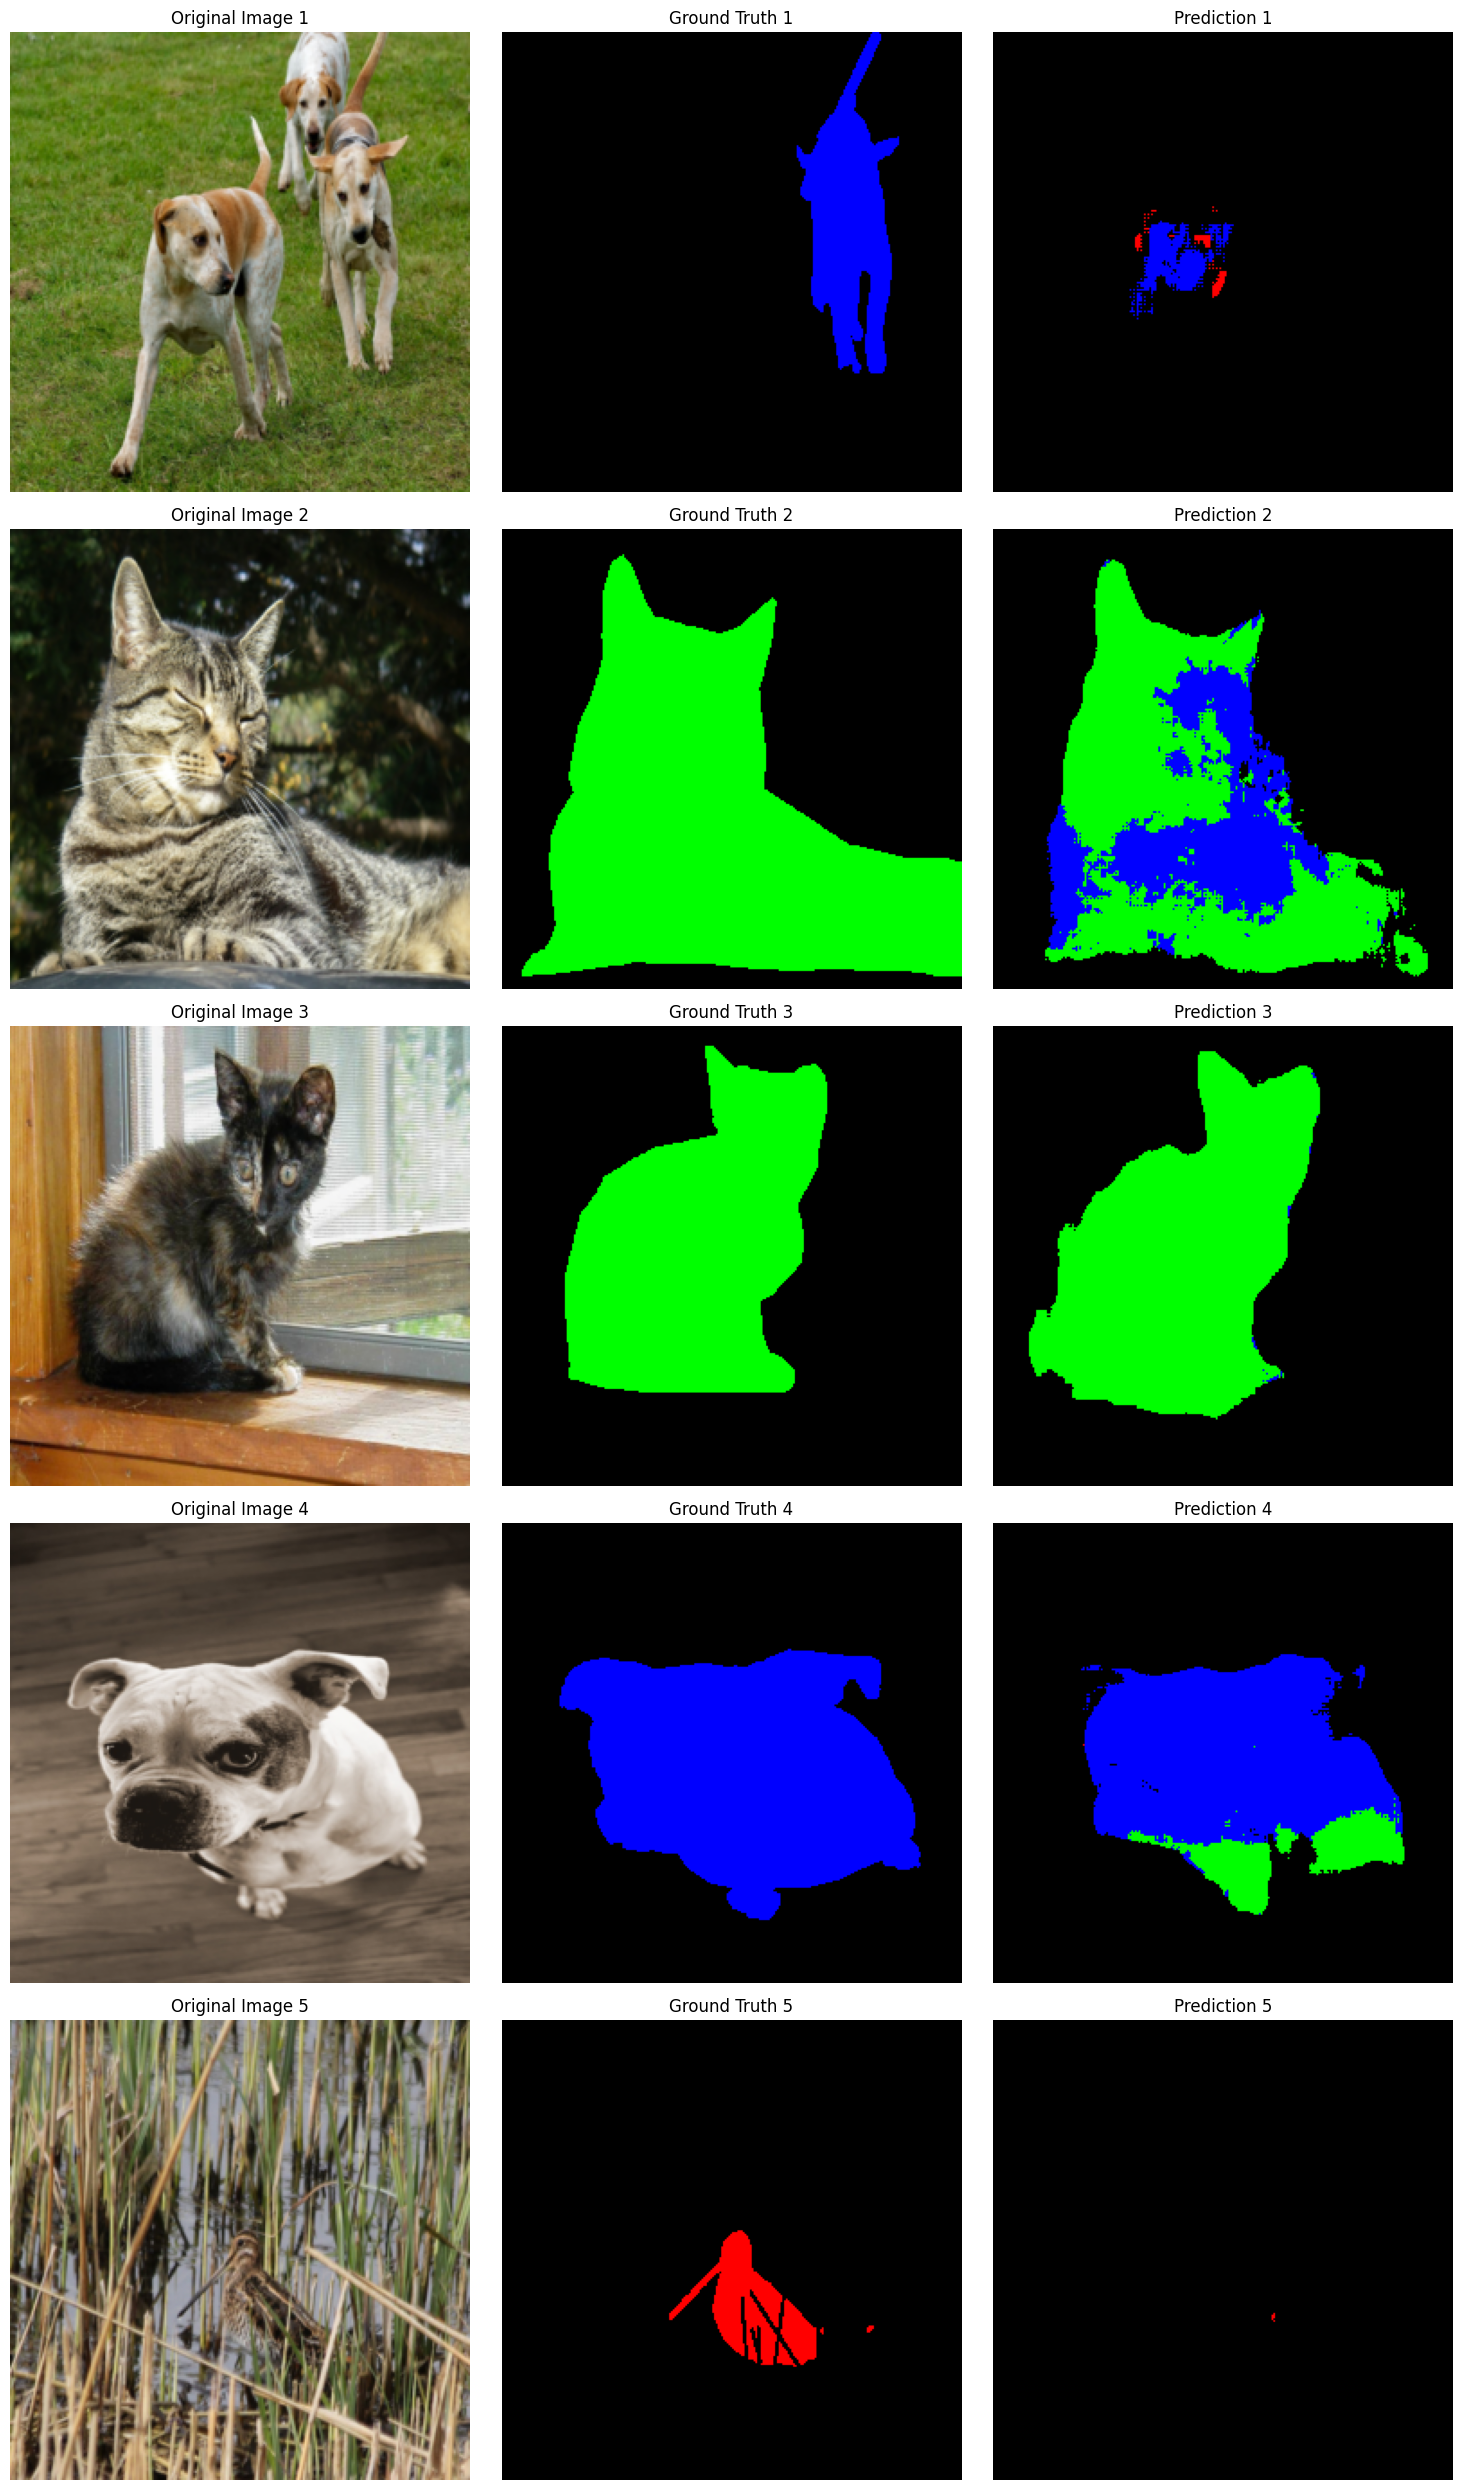

In [19]:
drive_path = "/content/drive/MyDrive/segmentation"
model_save_path = os.path.join(drive_path, "segmentation_model.pth")

if os.path.exists(model_save_path):
    print(f"Loading saved model from {model_save_path}")
    model.load_state_dict(torch.load(model_save_path, map_location=device))

    print("Evaluating loaded model:")
    test_dice, test_micro_f1, test_macro_f1 = evaluate(model, test_loader, device, num_classes)

    print(f"Test Dice Score: {np.mean(test_dice):.4f}")
    print(f"Test Micro-F1: {test_micro_f1:.4f}")
    print(f"Test Macro-F1: {test_macro_f1:.4f}")

    print("Per-class Dice scores:")
    for i, dice in enumerate(test_dice):
        class_name = "Background" if i == 0 else selected_classes[i-1]
        print(f"  {class_name}: {dice:.4f}")

    visualize_predictions(model, test_dataset, device, num_samples=5)

else:
    print("No saved model found. Training from scratch...")
    num_epochs = 50
    learning_rate = 1e-3

    metrics = train_and_eval(
        model,
        train_loader,
        test_loader,
        device,
        num_classes=num_classes,
        epoch_count=num_epochs,
        lr=learning_rate
    )

    plot_metrics(metrics)

    visualize_predictions(model, test_dataset, device, num_samples=5)

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print("Final evaluation on test data:")
    test_dice, test_micro_f1, test_macro_f1 = evaluate(model, test_loader, device, num_classes)

    print(f"Test Dice Score: {np.mean(test_dice):.4f}")
    print(f"Test Micro-F1: {test_micro_f1:.4f}")
    print(f"Test Macro-F1: {test_macro_f1:.4f}")

    print("Per-class Dice scores:")
    for i, dice in enumerate(test_dice):
        class_name = "Background" if i == 0 else selected_classes[i-1]
        print(f"  {class_name}: {dice:.4f}")